In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn')

In [2]:
# Load datasets
customers_df = pd.read_csv(r'C:\Users\crai8\Downloads\Customers.csv')
products_df = pd.read_csv(r'C:\Users\crai8\Downloads\Products.csv')
transactions_df = pd.read_csv(r'C:\Users\crai8\Downloads\Transactions.csv')

print("Data loaded successfully!")

Data loaded successfully!


In [3]:
# Create customer features for clustering
def create_clustering_features():
    # Transaction-based features
    customer_features = transactions_df.groupby('CustomerID').agg({
        'TransactionID': 'count',  # Purchase frequency
        'Quantity': ['sum', 'mean'],  # Purchase quantity
        'TotalValue': ['sum', 'mean', 'max']  # Monetary value
    }).round(2)
    
    # Flatten column names
    customer_features.columns = ['purchase_frequency', 'total_quantity', 'avg_quantity',
                               'total_spent', 'avg_transaction', 'max_transaction']
    
    # Add recency feature
    transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])
    last_transaction_date = transactions_df.groupby('CustomerID')['TransactionDate'].max()
    most_recent_date = transactions_df['TransactionDate'].max()
    customer_features['recency'] = (most_recent_date - last_transaction_date).dt.days
    
    # Add category preferences
    trans_products = transactions_df.merge(products_df, on='ProductID')
    category_preferences = pd.get_dummies(trans_products['Category'])
    category_preferences = category_preferences.multiply(trans_products['TotalValue'], axis=0)
    category_preferences = category_preferences.groupby(trans_products['CustomerID']).sum()
    
    # Combine features
    customer_features = customer_features.join(category_preferences)
    
    return customer_features

# Create features
customer_features = create_clustering_features()
print("Features created successfully!")
print(f"Number of features: {customer_features.shape[1]}")

Features created successfully!
Number of features: 11


In [4]:
# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features)
scaled_features_df = pd.DataFrame(scaled_features, 
                                index=customer_features.index,
                                columns=customer_features.columns)

print("Features scaled successfully!")

Features scaled successfully!


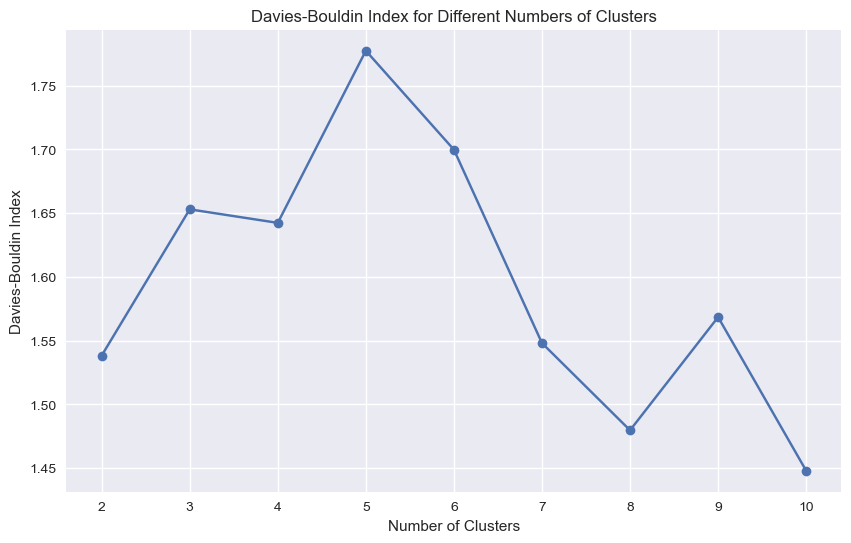


Optimal number of clusters based on DB Index: 10
Best DB Index score: 1.4481


In [5]:
# Calculate DB Index for different numbers of clusters
db_scores = []
n_clusters_range = range(2, 11)

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)
    db_score = davies_bouldin_score(scaled_features, clusters)
    db_scores.append(db_score)

# Plot DB Index scores
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, db_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index for Different Numbers of Clusters')
plt.grid(True)
plt.show()

# Find optimal number of clusters
optimal_clusters = n_clusters_range[np.argmin(db_scores)]
print(f"\nOptimal number of clusters based on DB Index: {optimal_clusters}")
print(f"Best DB Index score: {min(db_scores):.4f}")

Cluster Analysis:
         purchase_frequency  total_spent  avg_transaction  recency
Cluster                                                           
0                      8.60      6747.98           797.28    35.27
1                      2.45      1856.22           791.94   222.18
2                      4.41      2785.67           645.01    37.36
3                      2.30       721.98           323.46   132.10
4                      3.59      2278.59           655.01    57.62
5                      7.42      5338.13           734.75    47.05
6                      5.41      3961.68           741.66    56.82
7                      4.29      4420.54          1060.37    93.29
8                      5.77      4761.07           859.37    69.32
9                      6.60      2997.42           460.00    66.65


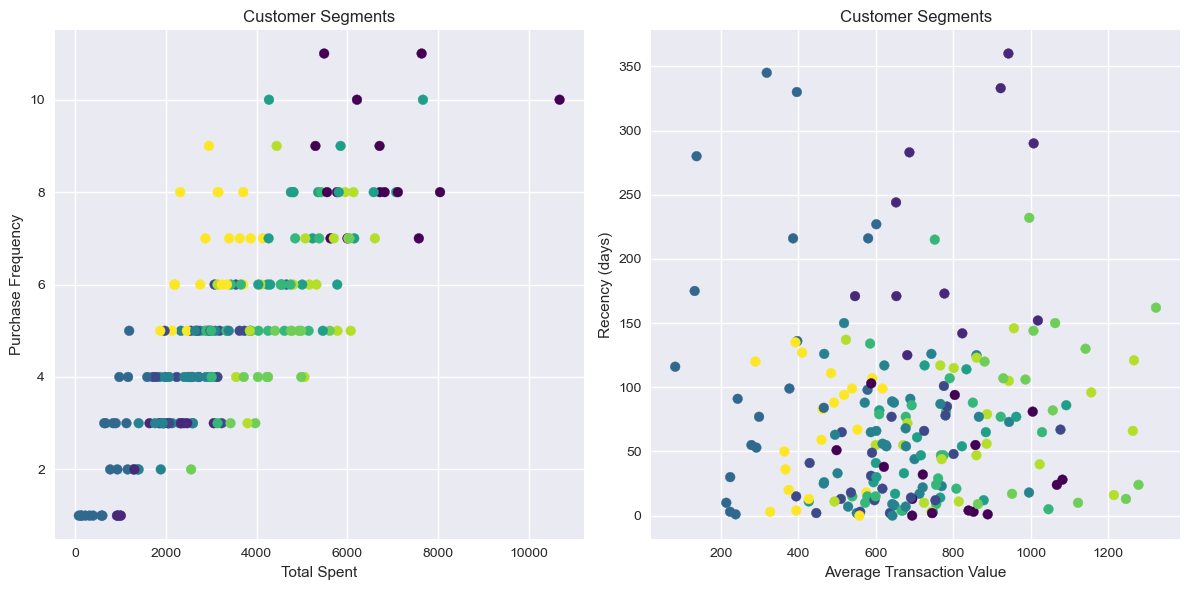

In [6]:
# Perform clustering with optimal number of clusters
final_kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_features['Cluster'] = final_kmeans.fit_predict(scaled_features)

# Analyze clusters
cluster_analysis = customer_features.groupby('Cluster').agg({
    'purchase_frequency': 'mean',
    'total_spent': 'mean',
    'avg_transaction': 'mean',
    'recency': 'mean'
}).round(2)

print("Cluster Analysis:")
print(cluster_analysis)

# Visualize clusters
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(customer_features['total_spent'], 
           customer_features['purchase_frequency'],
           c=customer_features['Cluster'], 
           cmap='viridis')
plt.xlabel('Total Spent')
plt.ylabel('Purchase Frequency')
plt.title('Customer Segments')

plt.subplot(1, 2, 2)
plt.scatter(customer_features['avg_transaction'], 
           customer_features['recency'],
           c=customer_features['Cluster'], 
           cmap='viridis')
plt.xlabel('Average Transaction Value')
plt.ylabel('Recency (days)')
plt.title('Customer Segments')

plt.tight_layout()
plt.show()